In [ ]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [1]:
import sys
import logging, os
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

sys.path.append('../../')

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"

In [3]:
### scale to natural units (ion height)
scale = 40e-6
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    s = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s, scale=scale/1e-6,
        rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
        18869: "DC2", 20943: "RF", 18129: "DC4"}))

dropping 0


In [4]:
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)
    result.to_vtk(prefix)
    print "finished job %s" % job.name
    return job.collect_charges()

In [ ]:
# set .1 max area within 3
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),    # areas_from_constraints specifies a region with finer mesh.
           radius=2, inside=.2, outside=10.))    # inside, outside assign the mesh density.
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)

In [160]:
# grid to evalute potential and fields at
n, s = 2*100, 1
grid = Grid(center=(0, 0, 0), step=(s, s/2., s), shape=(n/2, n/2, n/3))    # shape: the calculation region
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() is to 
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
pmap(run_job, ((job, grid, prefix) for job in jobs))

finished job DC1
finished job DC3
finished job DC5
finished job DC2
finished job RF
finished job DC4


[array([ 4.02019404, -0.95153122, -0.24915251, -0.07075638, -1.62537428,
        -0.1260678 ]),
 array([-0.9112266 ,  3.77945921, -0.07109569, -1.05952053, -0.40074672,
        -0.92468139]),
 array([-0.23046195, -0.06933327,  5.27685087, -0.01436503, -4.40913574,
        -0.22868745]),
 array([-0.06890335, -1.10624847, -0.0143822 ,  1.40337215, -0.06127194,
        -0.06909006]),
 array([-1.43711237, -0.3928297 , -4.38723945, -0.06156489, 10.43767633,
        -1.4403574 ]),
 array([-0.12564693, -0.95090236, -0.24719154, -0.07072878, -1.62821074,
         4.01641151])]

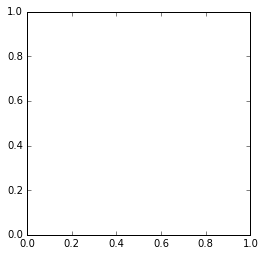

In [161]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential    # p.shape is a tuple that stores the length of x, y, z, respectively.
x = grid.to_mgrid()#[:, p.shape[0]/2]    # p.shape[0]/2 is in the middle of x. ?
#p = p[p.shape[0]/2]    # get the slice of yz plain at x = p.shape[0]/2, the middle plain.
fig, ax = plt.subplots()
ax.set_aspect("equal")
#ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-4, 50), cmap=plt.cm.Reds)

In [162]:
x.shape

(3, 60, 30, 20)

In [163]:
x[:,p.shape[0]/2].shape    # slice at nx/2

(3, 30, 20)

In [164]:
p[0,0,0], p[0,29,0]    # wwc the length of yz

(3.99669e-06, 8.97829e-06)

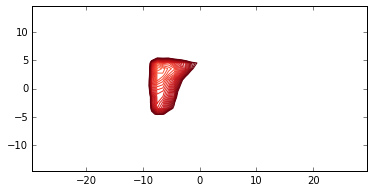

In [306]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "DC1")
p = result.potential
x = grid.to_mgrid()[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, 8e-3, 50), cmap=plt.cm.Reds)

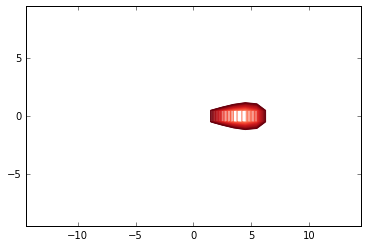

In [313]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "DC1")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 50), cmap=plt.cm.Reds)

In [287]:
x

array([[[-29.5, -29.5, -29.5, ..., -29.5, -29.5, -29.5],
        [-28.5, -28.5, -28.5, ..., -28.5, -28.5, -28.5],
        [-27.5, -27.5, -27.5, ..., -27.5, -27.5, -27.5],
        ...,
        [ 27.5,  27.5,  27.5, ...,  27.5,  27.5,  27.5],
        [ 28.5,  28.5,  28.5, ...,  28.5,  28.5,  28.5],
        [ 29.5,  29.5,  29.5, ...,  29.5,  29.5,  29.5]],

       [[-14.5, -13.5, -12.5, ...,  12.5,  13.5,  14.5],
        [-14.5, -13.5, -12.5, ...,  12.5,  13.5,  14.5],
        [-14.5, -13.5, -12.5, ...,  12.5,  13.5,  14.5],
        ...,
        [-14.5, -13.5, -12.5, ...,  12.5,  13.5,  14.5],
        [-14.5, -13.5, -12.5, ...,  12.5,  13.5,  14.5],
        [-14.5, -13.5, -12.5, ...,  12.5,  13.5,  14.5]],

       [[  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
        [  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
        [  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
        ...,
        [  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
        [  0.5,   0.5,   0.5, ...,   0.5,   0

In [259]:
print(p[0,14,9], p[59,14,9])
print(p[20,14,9], p[39,14,9])  # x

(0.0129035, 0.0129236)
(0.00974293, 0.00967623)


In [260]:
print(p[29,0,9], p[29,29,9])
print(p[29,10,9], p[29,19,9])  # y

(0.0651112, 0.0135111)
(0.511268, 0.0041881)


In [254]:
print(p[29,14,0], p[29,14,19])
print(p[29,14,5], p[29,14,14])  # z

(0.032727, 0.032727)
(0.0640706, 0.0640706)


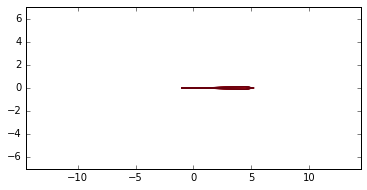

In [110]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "DC2")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-4, 50), cmap=plt.cm.Reds)

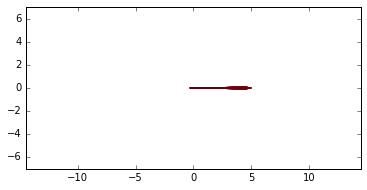

In [82]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "DC3")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 5e-4, 50), cmap=plt.cm.Reds)

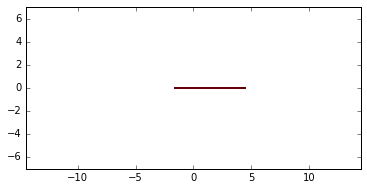

In [85]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "DC4")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 5e-4, 50), cmap=plt.cm.Reds)

In [ ]:
np.shape(result.potential)

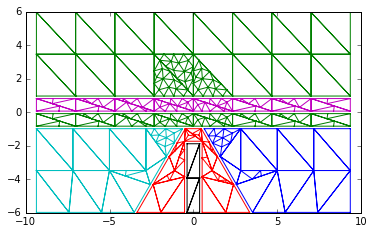

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [1]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()


NameError: name 'Result' is not defined

In [9]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r)
    e.name = name
    s.append(e)
s["RF"].rf = 1.

ImportError: No module named electrode

In [10]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass, u=50.,
                          l=40e-6, o=100e6*2*np.pi):
    print _

AttributeError: 'float' object has no attribute 'minimum'

In [11]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)

AttributeError: 'float' object has no attribute 'potential'